# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
import math
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

from scipy.optimize import brentq
from ema_workbench import Model, RealParameter, ScalarOutcome, SequentialEvaluator, perform_experiments, TimeSeriesOutcome
from ema_workbench import MultiprocessingEvaluator, ema_logging 
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting
from lakemodel_function import lake_problem

In [2]:
model = Model('LAKE', function=lake_problem)

# Setting the model uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.98)]

# Assigning the model levers

model.levers = [RealParameter('l' + str(i), 0, 0.1) for i in range(100)]

# Deciding upon the outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=10)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
experiments, outcomes = results
experiments = experiments.drop(columns=(('l' + str(i)) for i in range(100)))
print(experiments)

             b     delta      mean         q     stdev scenario policy model
0     0.266317  0.952421  0.049728  3.756696  0.004122        0      0  LAKE
1     0.441233  0.940863  0.040774  3.910445  0.004436        1      0  LAKE
2     0.370256  0.978532  0.042145  4.352734  0.003477        2      0  LAKE
3     0.255953  0.937672  0.047541  3.868305  0.002072        3      0  LAKE
4     0.223862  0.946035  0.047695  4.181668  0.002219        4      0  LAKE
...        ...       ...       ...       ...       ...      ...    ...   ...
9995  0.449710  0.979682  0.015374  2.034124  0.002799      995      9  LAKE
9996  0.352749  0.957013  0.013814  3.597554  0.002737      996      9  LAKE
9997  0.172188  0.936344  0.020019  3.313589  0.003264      997      9  LAKE
9998  0.271741  0.977798  0.033521  2.590566  0.003253      998      9  LAKE
9999  0.305325  0.945958  0.033391  2.534846  0.004161      999      9  LAKE

[10000 rows x 8 columns]


In [5]:
policies = experiments['policy']

for i, policy in enumerate(np.unique(policies)):
    experiments.loc[experiments['policy']==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies

print(experiments)

             b     delta      mean         q     stdev scenario policy model
0     0.266317  0.952421  0.049728  3.756696  0.004122        0      0  LAKE
1     0.441233  0.940863  0.040774  3.910445  0.004436        1      0  LAKE
2     0.370256  0.978532  0.042145  4.352734  0.003477        2      0  LAKE
3     0.255953  0.937672  0.047541  3.868305  0.002072        3      0  LAKE
4     0.223862  0.946035  0.047695  4.181668  0.002219        4      0  LAKE
...        ...       ...       ...       ...       ...      ...    ...   ...
9995  0.449710  0.979682  0.015374  2.034124  0.002799      995      9  LAKE
9996  0.352749  0.957013  0.013814  3.597554  0.002737      996      9  LAKE
9997  0.172188  0.936344  0.020019  3.313589  0.003264      997      9  LAKE
9998  0.271741  0.977798  0.033521  2.590566  0.003253      998      9  LAKE
9999  0.305325  0.945958  0.033391  2.534846  0.004161      999      9  LAKE

[10000 rows x 8 columns]


C:\Users\Sarah\anaconda3\envs\mbdm\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Sarah\anaconda3\envs\mbdm\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Sarah\anaconda3\envs\mbdm\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


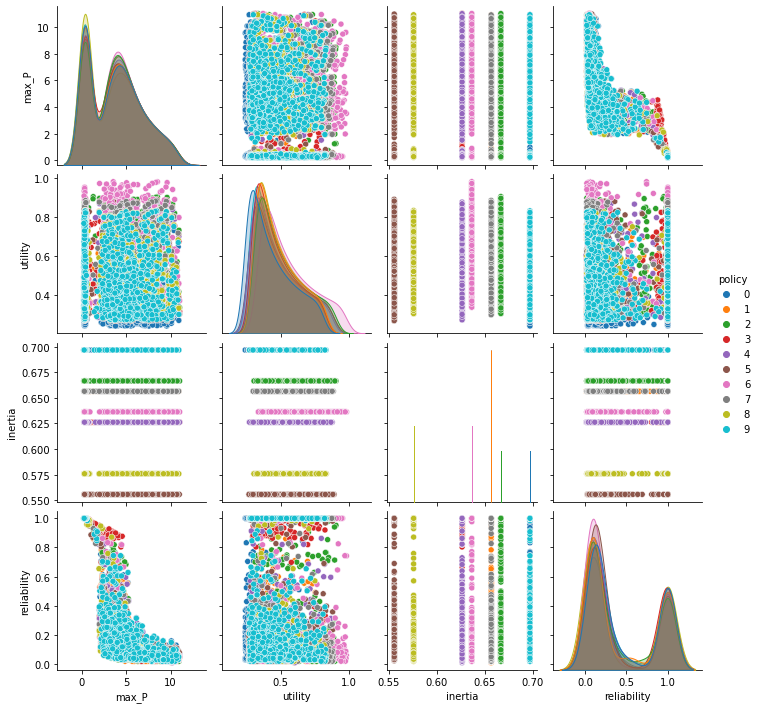

In [6]:
sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

In [7]:
worst10 = sorted(outcomes['reliability'])[:int((0.1 * len(outcomes['reliability'])))]
worst = worst10[-1:][0]
print(worst)

0.05000000000000004


In [8]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes['reliability'] < worst
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 800 cases of interest
[MainProcess/INFO] mean: 0.9055555555555556, mass: 0.054, coverage: 0.61125, density: 0.9055555555555556 restricted_dimensions: 3


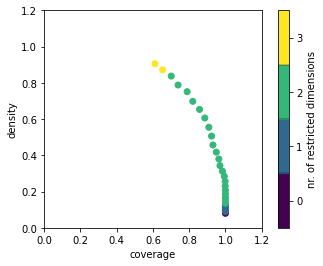

In [9]:
box1.show_tradeoff()
plt.show()

coverage     0.65375
density     0.871667
id                26
mass            0.06
mean        0.871667
res_dim            3
Name: 26, dtype: object

        box 26                                          
           min       max                       qp values
q     2.000010  2.542914  [-1.0, 3.000625807474091e-248]
b     0.100127  0.203073  [-1.0, 3.296260456670242e-161]
mean  0.013702  0.050000     [0.01131715679613358, -1.0]



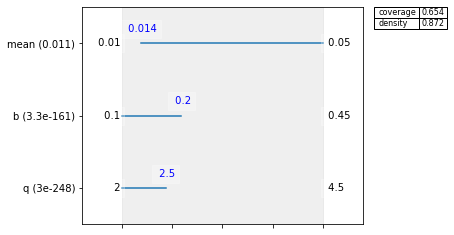

In [10]:
box1.inspect(26)
box1.inspect(26, style='graph')
plt.show()

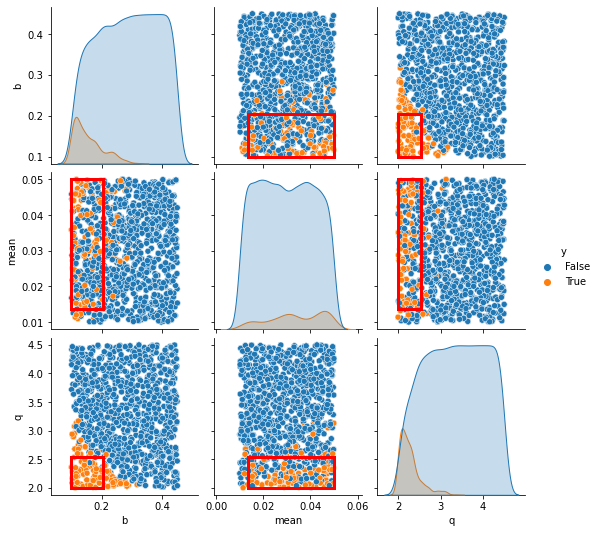

In [11]:
box1.select(26)
fig = box1.show_pairs_scatter()
plt.show()

In [12]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 9400 points remaining, containing 277 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.3295880149812734, returning dump box


## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category


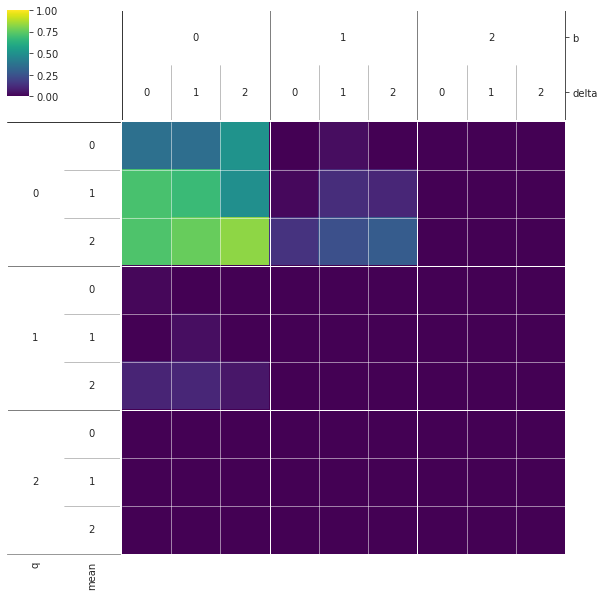

In [13]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = outcomes['reliability'] < worst
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

It is clear from the plot that when uncertainty b and q both are in the lowest category 0, the reliability can be expected to be above the desired threshold. This is also seen in the scatterplot of the scenario discovery, since the plot for b and q shows a box in the lower left corner where both b and q are very low.